Kate Alexandra R. Fabro


# **DATA103 Activity: Feature Selection and Data Handling Methods**


**Objective**: To assess your ability to implement code, analyze, and comprehend the concepts of feature selection, handling imbalanced data, missing data, and types of missing data.

**1. Data Exploration and Preprocessing**

The following code entails the below:
* Load the dataset and perform basic exploratory data analysis (EDA).
* Identify and analyze the types of missing data (MCAR, MAR, MNAR) based on domain knowledge and statistical tests.
* Justify your choice of missing data handling technique based on the identified type of missing data.
* Handle missing values using appropriate techniques - Imputation
*  Analyze the distribution of features and target variables.
* Normalize or standardize numerical features as needed.
* Encode categorical features using suitable methods (e.g., one-hot encoding, label encoding).


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
from pathlib import Path
datasets_folder = Path('/gdrive/MyDrive/datasets/')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

**1.1 Handling Missing Data via Imputation**


In [ ]:
mb_df = pd.read_csv(datasets_folder/'MBA.csv')
df = mb_df
df

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,NaN
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,NaN
6191,6192,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,NaN,590.0,5.0,Other,NaN


**1.1.1 Type of Missing Data (MCAR)**

Little MCARs Test

In [ ]:
import scipy.stats as stats
df_test = df
df_test['admission_missing'] = df_test['admission'].isnull().astype(int)

with_missing = df_test[df_test['admission_missing'] == 1]['gpa']
without_missing = df_test[df_test['admission_missing'] == 0]['gpa']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(with_missing, without_missing, equal_var=False)

print("T-test results:", t_stat, p_value)

# Interpretation
if p_value < 0.05:
    print("Data is not MCAR")
else:
    print("Data is MCAR")

T-test results: -26.309835949151076 1.3331219498745145e-126
Data is not MCAR


**Analysis:** The t-test results indicate that the missing data in your dataset is not Missing Completely at Random (MCAR). With a t-test statistic of approximately -26.31 and an extremely low p-value of about 1.33×10−1261.33×10 −126 ,we reject the null hypothesis, concluding that the characteristics of the observed and missing data (GPA) significantly differ

In [ ]:
# Checking for missing values
df.isna().sum()

,0
application_id,0
gender,0
international,0
gpa,0
major,0
race,1842
gmat,0
work_exp,0
work_industry,0
admission,5194


Given that race and admission have missing values, I further assess the unique values

In [ ]:
# Race Unique Values
race_values = df['race'].unique()
race_values

array(['Asian', 'Black', nan, 'Hispanic', 'White', 'Other'], dtype=object)

In [ ]:
# Admission Unique Values
admission_values = df['admission'].unique()
admission_values

array(['Admit', nan, 'Waitlist'], dtype=object)

In [ ]:
admission_values = df['admission'].unique()
admission_values

array(['Admit', nan, 'Waitlist'], dtype=object)

In [ ]:
# Races with null values value count
race_group_count = df['race'].value_counts(dropna=False)
race_group_count

,count
race,
NaN,1842
White,1456
Asian,1147
Black,916
Hispanic,596
Other,237


In [ ]:
# Courses with null values value count
admission_missing_by_group_1 = df.groupby('major')['admission'].apply(lambda x: x.isnull().sum())
admission_missing_by_group_1

,admission
major,
Business,1546
Humanities,2073
STEM,1575


In [ ]:
# Courses with null values value count
admission_missing_by_group_2 = df.groupby('race')['admission'].apply(lambda x: x.isnull().sum())
admission_missing_by_group_2

,admission
race,
Asian,935
Black,826
Hispanic,526
Other,187
White,1186


For Race, we assess the International Column by taking the mode (the most frequent) either true or false, to determine if indeed the race can be part of the "Other" value count

In [ ]:
mode_international_nan_race = df[df['race'].isna()]['international'].mode()
mode_international_nan_race

,international
0,True


Since, the most frequent is True, we can replace the null values with "Other" and add to the value count of the like


In [ ]:
# Replace null values in 'race' column with "Other"
df = df.assign(race=df['race'].fillna('Other'))

In [ ]:
# To make sure we got rid of the NaN values
race_values_final = df['race'].unique()
race_values_final

array(['Asian', 'Black', 'Other', 'Hispanic', 'White'], dtype=object)

For Admission, we assess the average gpa of the null values, and if the gpa average is below 3.30, we can assign a value of "Deny"
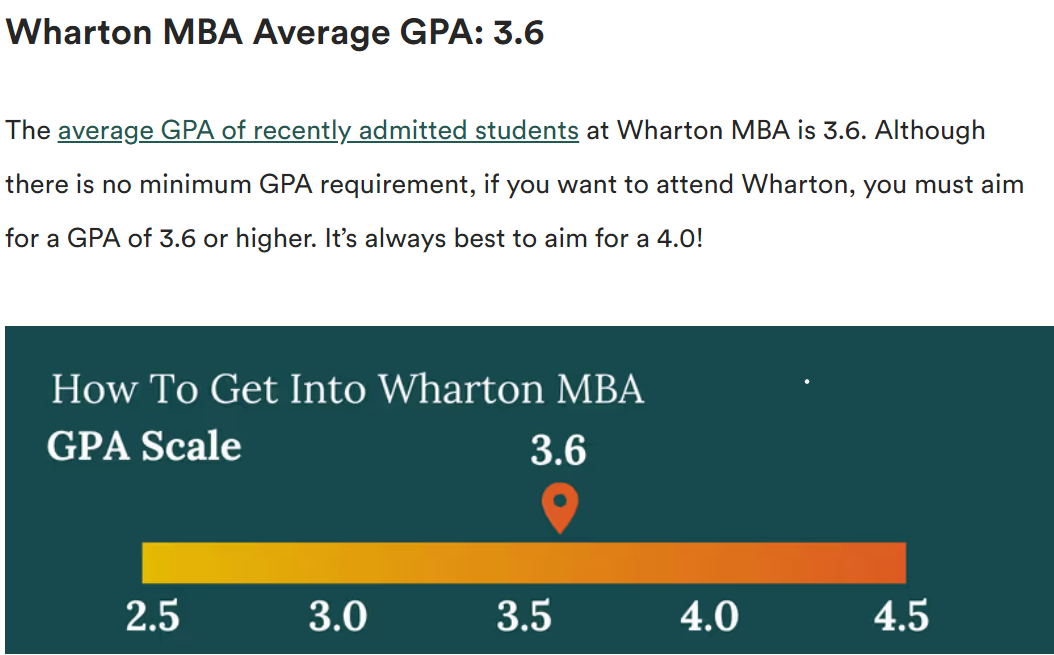

image source: https://www.inspirafutures.com/blog/wharton-mba-program#b3

In [ ]:
# Calculate the average GPA where Admission is NaN
average_gpa_nan_admission = df[df['admission'].isna()]['gpa'].mean()
average_gpa_nan_admission

3.2314574509048906

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

df.loc[(df['admission'].isnull()) & (df['gpa'] < 3.2), 'admission'] = 'Reject'
df_final = pd.get_dummies(df, columns=['gender', 'major', 'race', 'work_industry'], drop_first=True).drop(columns=['application_id'])
df_final

X = df_final.drop(columns=['admission'])
y = df_final['admission']


X_train = X[~y.isna()]
y_train = y[~y.isna()]
X_test = X[y.isna()]

knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

predicted_admission = knn_classifier.predict(X_test)
df_final.loc[y.isna(), 'admission'] = predicted_admission

df_final

,international,gpa,gmat,work_exp,admission,admission_missing,gender_Male,major_Humanities,major_STEM,race_Black,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,False,3.30,620.0,3.0,Admit,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,3.28,680.0,5.0,Reject,1,True,True,False,True,...,False,False,True,False,False,False,False,False,False,False
2,True,3.30,710.0,5.0,Admit,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,3.47,690.0,6.0,Admit,1,True,False,True,True,...,False,False,False,False,False,False,False,False,False,True
4,False,3.35,590.0,5.0,Reject,1,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6189,False,3.49,640.0,5.0,Reject,1,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
6190,False,3.18,670.0,4.0,Reject,1,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
6191,True,3.22,680.0,5.0,Admit,0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6192,True,3.36,590.0,5.0,Reject,1,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
new_admissions = df_final['admission']
df['admission'] = new_admissions
df

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission,admission_missing
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit,0
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Reject,1
2,3,Female,True,3.30,Business,Other,710.0,5.0,Technology,Admit,0
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Admit,1
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Reject,1
...,...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,Reject,1
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,Reject,1
6191,6192,Female,True,3.22,Business,Other,680.0,5.0,Health Care,Admit,0
6192,6193,Male,True,3.36,Business,Other,590.0,5.0,Other,Reject,1


In [ ]:
# To make sure we got rid of the NaN values
admission_values_final = df_final['admission'].unique()
admission_values_final

array(['Admit', 'Reject', 'Waitlist'], dtype=object)


The code replaces missing `admission` values with 'Reject' for rows where GPA is below 3.2, uses K-Nearest Neighbors (KNN) to predict remaining NaN values based on other features after applying one-hot encoding to categorical variables, and then updates the dataset with the predicted values.

In [ ]:
# remove unecessary columns
columns_to_drop = ['application_id','international']
df = df.drop(columns=columns_to_drop)

Final checking for null values

In [ ]:
df.isna().sum()

,0
gender,0
gpa,0
major,0
race,0
gmat,0
work_exp,0
work_industry,0
admission,0
admission_missing,0


**1.3 Distribution of features and target variables**

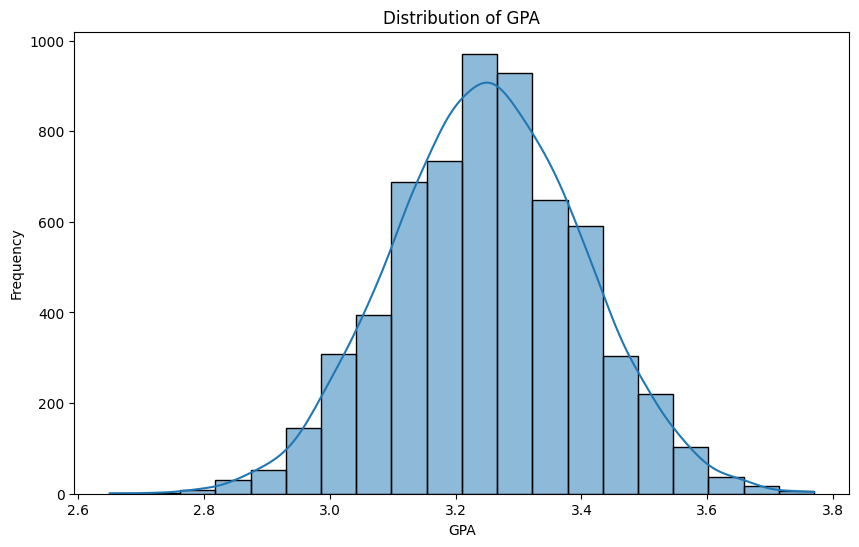

In [ ]:
# GPA Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['gpa'], bins=20, kde=True)
plt.title("Distribution of GPA")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.show()

**Analysis:**

* The GPA distribution is approximately normal with a bell-shaped curve, centered around 3.2 to 3.4, indicating that most students perform within this range.
* There is a slight skew towards lower GPAs, but there are no significant outliers, suggesting relatively consistent academic performance across the dataset.

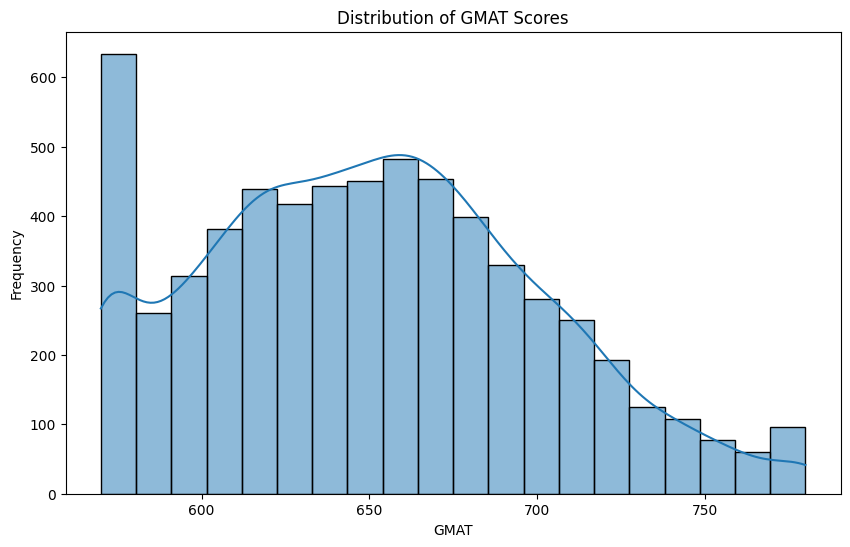

In [ ]:
# GMAT Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['gmat'], bins=20, kde=True)
plt.title('Distribution of GMAT Scores')
plt.xlabel('GMAT')
plt.ylabel('Frequency')
plt.show()

**Analysis:**

* The GMAT distribution is right-skewed, with most students scoring between 600 and 650, and fewer students achieving scores above 700.
* A noticeable spike at the 600 score may indicate a common threshold or target score among applicants, potentially reflecting admission criteria or typical performance.

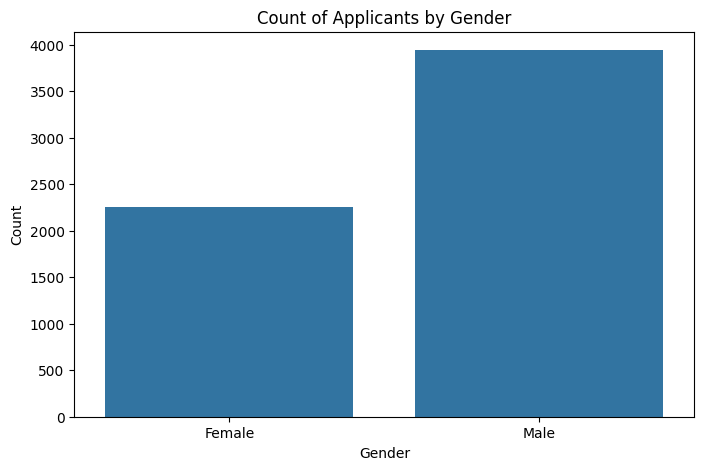

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=df)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Applicants by Gender')
plt.show()

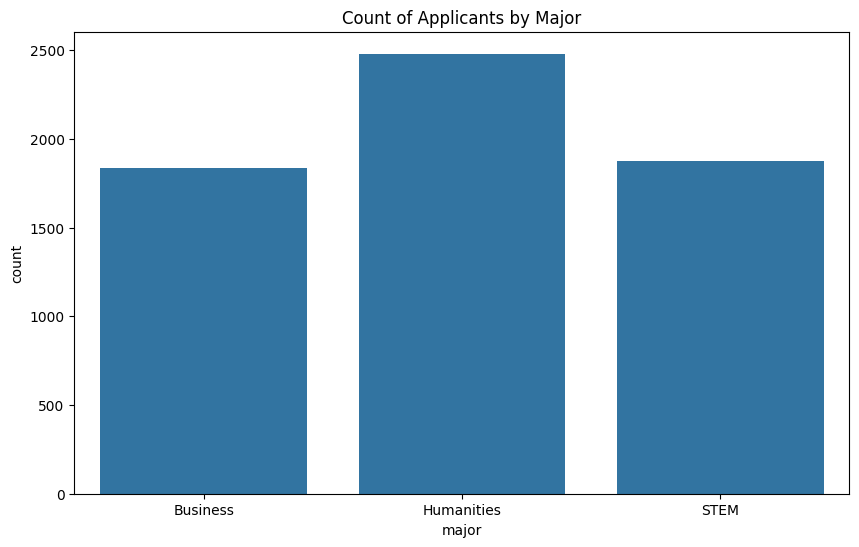

In [ ]:
# Major Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='major', data=df)
plt.title('Count of Applicants by Major')
plt.show()

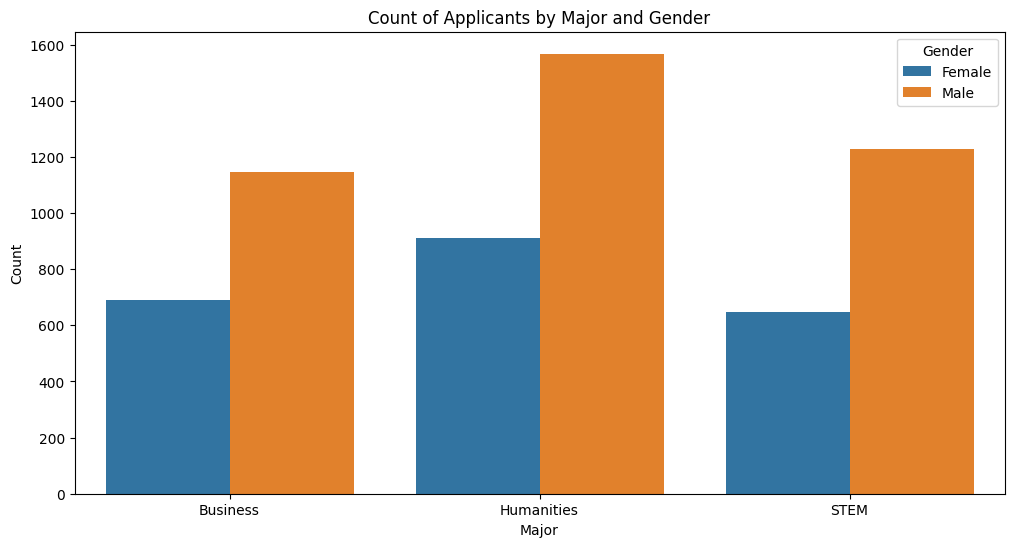

In [ ]:
# Major Distribution by Gender
plt.figure(figsize=(12, 6))
sns.countplot(x='major', data=df, hue='gender')
plt.xlabel('Major')
plt.ylabel('Count')
plt.title('Count of Applicants by Major and Gender')
plt.legend(title='Gender')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.show()

**Analysis:**

* Humanities attract the highest number of male applicants by a large margin (around 1,600), which might indicate either a societal or educational trend where males are more inclined towards this field.

* Although male dominance is still evident in STEM, the substantial number of female applicants signals positive movement toward gender balance, possibly reflecting the impact of initiatives to attract women to science and technology fields.

* The relatively smaller gap between male and female applicants in Business could indicate that this major is perceived as more gender-neutral or welcoming to both genders. The field might offer broader career opportunities or fewer gendered stereotypes, making it a more attractive option for diverse applicants.

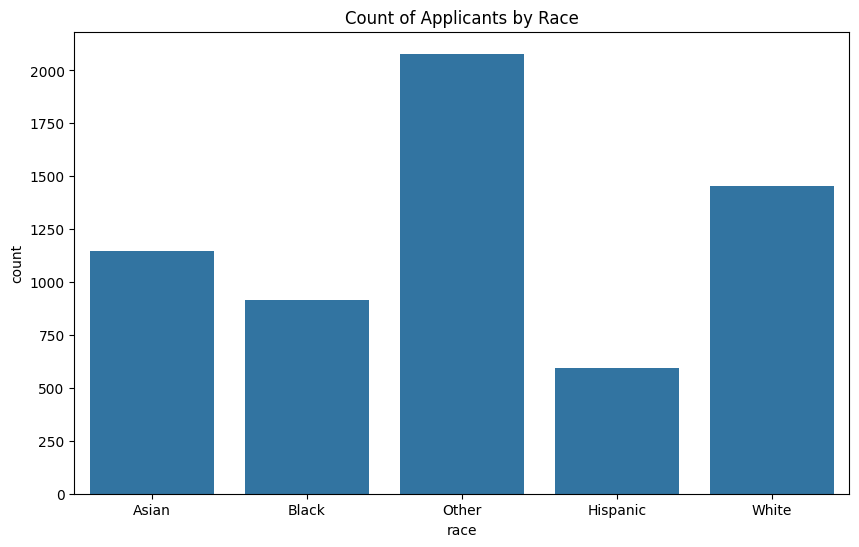

In [ ]:
# Race Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='race', data=df)
plt.title('Count of Applicants by Race')
plt.show()

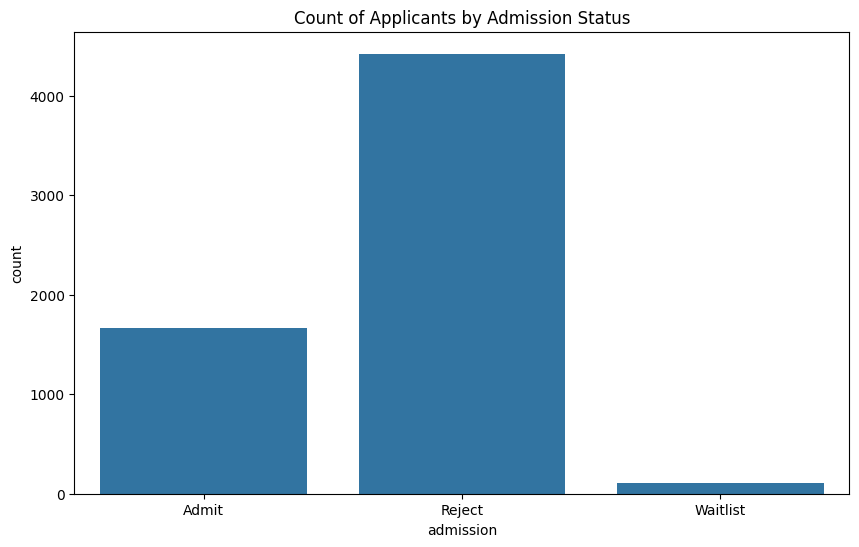

In [ ]:
# Admission Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='admission', data=df)
plt.title('Count of Applicants by Admission Status')
plt.show()

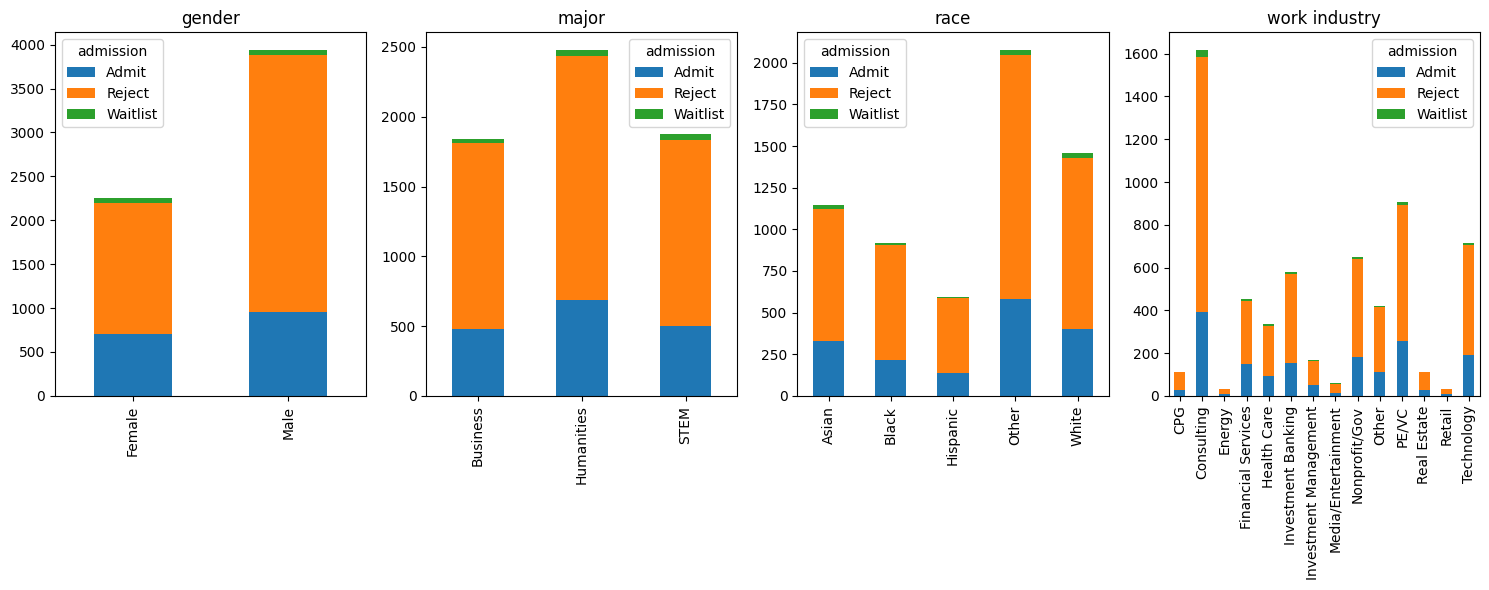

In [ ]:
cats = ["gender", "major", "race", "work_industry", "admission"]
nums = [i for i in df.columns if i not in cats]

fig, axes = plt.subplots(ncols=len(cats[:-1]), figsize=(15, 6))

for i, j in enumerate(cats[:-1]):
    df.groupby(j)[cats[-1]].value_counts().unstack().plot(kind="bar", ax=axes[i], stacked=True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_title(j.replace("_", " "))
plt.tight_layout()
plt.show()

**Analysis:**

* Both males and females experience a high rate of denials, but males have a larger total applicant pool, with slightly more admissions than females. The waitlist proportions are similar for both genders, indicating that admission outcomes are relatively consistent across genders despite the larger male applicant pool.

* International students face higher denial rates compared to domestic (false) students. Among races, applicants identified as "Other" have the highest denial rates and the largest total applicant pool, while White and Asian applicants have a comparatively better chance of being admitted, although denial rates are still substantial across all groups.

* Consulting stands out as the most popular industry for applicants, with a notably high denial rate despite the large pool. Financial Services, Technology, and Health Care also have significant applicant pools, but admit rates are similarly low across most industries, indicating competitive fields regardless of industry experience.

**1.4 Encoding of Categorical Variables**

In [ ]:
categorical_data = ['gender', 'major', 'race',
       'work_industry', 'admission']
for column in df[categorical_data]:
    print(f" {column} : {df[column].unique()}")

 gender : ['Female' 'Male']
 major : ['Business' 'Humanities' 'STEM']
 race : ['Asian' 'Black' 'Other' 'Hispanic' 'White']
 work_industry : ['Financial Services' 'Investment Management' 'Technology' 'Consulting'
 'Nonprofit/Gov' 'PE/VC' 'Health Care' 'Investment Banking' 'Other'
 'Retail' 'Energy' 'CPG' 'Real Estate' 'Media/Entertainment']
 admission : ['Admit' 'Reject' 'Waitlist']


In [ ]:
df_0 = pd.DataFrame()

# Encode the variables from df_final into df_0
df_0['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df_0['admission'] = df['admission'].map({'Admit': 1, 'Waitlist': 0, 'Reject': 0})
df_0['race'] = df['race'].map({'White': 0, 'Asian': 1, 'Black': 2, 'Hispanic': 3, 'Other': 4})
df_0['major'] = df['major'].map({'Business': 1, 'Humanities': 2, 'STEM': 3})

df_0['gpa'] = df['gpa']
df_0['gmat'] = df['gmat']
df_0['work_exp'] = df['work_exp']
df_0['work_industry'] = df['work_industry']

df_0

,gender,admission,race,major,gpa,gmat,work_exp,work_industry
0,1,1,1,1,3.30,620.0,3.0,Financial Services
1,0,0,2,2,3.28,680.0,5.0,Investment Management
2,1,1,4,1,3.30,710.0,5.0,Technology
3,0,1,2,3,3.47,690.0,6.0,Technology
4,0,0,3,3,3.35,590.0,5.0,Consulting
...,...,...,...,...,...,...,...,...
6189,0,0,0,1,3.49,640.0,5.0,Other
6190,0,0,2,3,3.18,670.0,4.0,Consulting
6191,1,1,4,1,3.22,680.0,5.0,Health Care
6192,0,0,4,1,3.36,590.0,5.0,Other


In [ ]:
# Define the mapping for work industry
industry_mapping = {
    'Technology': 1,
    'PE/VC': 2,
    'Consulting': 3,
    'Investment Management': 4,
    'Other': 5,
    'Investment Banking': 5,
    'Financial Services': 6,
    'Nonprofit/Gov': 7,
    'Real Estate': 8,
    'Health Care': 9,
    'CPG': 10,
    'Media/Entertainment': 11,
    'Retail': 12,
    'Energy': 13
}

df_0['work_industry'] = df_0['work_industry'].map(industry_mapping)

df_0


,gender,admission,race,major,gpa,gmat,work_exp,work_industry
0,1,1,1,1,3.30,620.0,3.0,6
1,0,0,2,2,3.28,680.0,5.0,4
2,1,1,4,1,3.30,710.0,5.0,1
3,0,1,2,3,3.47,690.0,6.0,1
4,0,0,3,3,3.35,590.0,5.0,3
...,...,...,...,...,...,...,...,...
6189,0,0,0,1,3.49,640.0,5.0,5
6190,0,0,2,3,3.18,670.0,4.0,3
6191,1,1,4,1,3.22,680.0,5.0,9
6192,0,0,4,1,3.36,590.0,5.0,5


**1.4.1 Type of Missing Variable (MAR and MNAR)**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Drop rows where 'admission' and 'race' are missing
df_cleaned = df_0.dropna(subset=['admission', 'race'])

# Convert categorical columns to numeric (e.g., gender, major)
df_cleaned = pd.get_dummies(df_cleaned, drop_first=True)

# Check for multicollinearity using the correlation matrix
correlation_matrix = df_cleaned.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Prepare the data for Little's MCAR test
def little_mcar_test(dataframe):
    n = dataframe.shape[0]
    missing_data = dataframe.isnull()
    missing_sum = missing_data.sum(axis=1)
    dataframe['missing_sum'] = missing_sum
    is_missing = (missing_sum > 0).astype(int)

    # Logistic Regression to test MCAR
    X = sm.add_constant(dataframe.drop(columns=['admission', 'race', 'missing_sum'], errors='ignore'))
    y = is_missing

    try:
        logit_model = sm.Logit(y, X).fit(disp=0)
        print(logit_model.summary())

        # Example summary based on the results
        if logit_model.pvalues.max() > 0.05:
            print("The missing data is likely MCAR.")
        else:
            print("The missing data is likely MAR or MNAR, as the missingness can be predicted by observed variables.")

        return logit_model
    except np.linalg.LinAlgError:
        print("Singular matrix encountered; check for multicollinearity or insufficient variability.")

# Run the MCAR test
mcar_model = little_mcar_test(df_cleaned)

# Testing for MAR
def test_mar(dataframe, target_variable):
    # Create a binary variable indicating if the target_variable is missing
    dataframe['missing_target'] = dataframe[target_variable].isnull().astype(int)

    # Logistic Regression to test MAR
    X = sm.add_constant(dataframe.drop(columns=[target_variable, 'missing_target'], errors='ignore'))
    y = dataframe['missing_target']

    try:
        mar_model = sm.Logit(y, X).fit(disp=0)
        print(mar_model.summary())

        if mar_model.pvalues.max() > 0.05:
            print("The missing data is likely MAR.")
        else:
            print("The missing data may be MNAR, as the missingness can be predicted by observed variables.")

        return mar_model
    except np.linalg.LinAlgError:
        print("Singular matrix encountered; check for multicollinearity or insufficient variability.")

# Run the MAR test for 'admission' variable
mar_model = test_mar(df_cleaned, 'admission')


Correlation Matrix:
                  gender  admission      race     major       gpa      gmat  \
gender         1.000000   0.076869  0.001140 -0.025773 -0.022210 -0.022815   
admission      0.076869   1.000000 -0.004999  0.008017  0.485316  0.626965   
race           0.001140  -0.004999  1.000000  0.004941 -0.012483 -0.004674   
major         -0.025773   0.008017  0.004941  1.000000 -0.006697  0.003594   
gpa           -0.022210   0.485316 -0.012483 -0.006697  1.000000  0.577539   
gmat          -0.022815   0.626965 -0.004674  0.003594  0.577539  1.000000   
work_exp       0.007427   0.027777 -0.010748  0.006741  0.000346 -0.000999   
work_industry -0.005270   0.007432  0.000559 -0.001222 -0.000195  0.011137   

               work_exp  work_industry  
gender         0.007427      -0.005270  
admission      0.027777       0.007432  
race          -0.010748       0.000559  
major          0.006741      -0.001222  
gpa            0.000346      -0.000195  
gmat          -0.000999       

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packa

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6194
Model:                          Logit   Df Residuals:                     6187
Method:                           MLE   Df Model:                            6
Date:                Sat, 19 Oct 2024   Pseudo R-squ.:                     inf
Time:                        14:20:51   Log-Likelihood:            -1.6742e-13
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -17.1187    4.6e+07  -3.72e-07      1.000   -9.02e+07    9.02e+07
gender           -0.0619    3.9e+06  -1.59e-08      1.000   -7.64e+06    7.64e+06
major            -0.1286   2.41e+06  -5.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packa

**Analysis:** Based on the correlation matrix, it appears that the missingness in admission may be classified as **MAR (Missing At Random)**. This ic soming from the strong negative correlations between admission and both gpa and gmat. Since the missingness in admission correlates with observed variables (GPA and GMAT scores), this suggests that the probability of missing data on admission is related to these performance metrics, indicating that the missingness can be explained by other measured variables.



In [ ]:
df_1 = pd.DataFrame()

df_1['gpa'] = df['gpa']
df_1['gmat'] = df['gmat']

# Use pd.get_dummies() to convert categorical variables into dummy variables
df_1 = pd.get_dummies(df, columns=['gender', 'race', 'major', 'work_exp', 'work_industry'], drop_first=True)

# For 'admission', map the values as specified
df_1['admission'] = df['admission'].map({'Admit': 1, 'Waitlist': 0, 'Reject': 0})

# Display the resulting DataFrame
df_1.head()


,gpa,gmat,admission,admission_missing,gender_Male,race_Black,race_Hispanic,race_Other,race_White,major_Humanities,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,3.30,620.0,1,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.28,680.0,0,1,True,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2,3.30,710.0,1,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,3.47,690.0,1,1,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,3.35,590.0,0,1,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**2. Feature Selection**

The following code entails the below:
* Implement at least two feature selection methods- Correlation and Recursive Feature Elimination).
* Feature Ranking
* Justification of Methods


**2.1 Correlation**

**Background:** The primary objective of analyzing this dataset is to identify significant predictors of admission status using techniques like correlation analysis, ultimately providing insights into the admissions process and aiding institutions in refining their evaluation criteria. Thus, the context of this data revolves around evaluating applicant profiles to enhance decision-making based on empirical evidence.

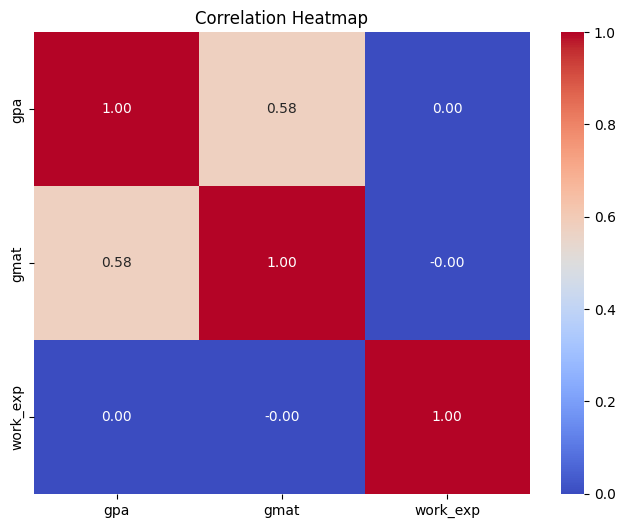

In [ ]:
# Correlation Heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(df_1[['gpa', 'gmat', 'work_exp']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Check for non-numeric columns in df_1
non_numeric_cols = df_1.select_dtypes(exclude='number').columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

# If the non-numeric columns are categorical, we can use one-hot encoding or similar techniques
df_1_encoded = pd.get_dummies(df_1, columns=non_numeric_cols, drop_first=True)

# Now calculate the correlation
threshold = 0.2

# Calculate the absolute correlation of the target variable with other features
corr_target = df_1_encoded.corr()['admission'].abs()
print("Correlation with admission:\n", corr_target)

selected_feat = corr_target[corr_target > threshold].index.tolist()
selected_feat = [feat for feat in selected_feat if feat != 'admission']


df_selected = df_1_encoded[selected_feat]
df_selected

Non-numeric columns: ['gender_Male', 'race_Black', 'race_Hispanic', 'race_Other', 'race_White', 'major_Humanities', 'major_STEM', 'work_exp_2.0', 'work_exp_3.0', 'work_exp_4.0', 'work_exp_5.0', 'work_exp_6.0', 'work_exp_7.0', 'work_exp_8.0', 'work_exp_9.0', 'work_industry_Consulting', 'work_industry_Energy', 'work_industry_Financial Services', 'work_industry_Health Care', 'work_industry_Investment Banking', 'work_industry_Investment Management', 'work_industry_Media/Entertainment', 'work_industry_Nonprofit/Gov', 'work_industry_Other', 'work_industry_PE/VC', 'work_industry_Real Estate', 'work_industry_Retail', 'work_industry_Technology']
Correlation with admission:
 gpa                                         0.485316
gmat                                        0.626965
admission                                   1.000000
admission_missing                           0.624424
gender_Male_True                            0.076869
race_Black_True                             0.034233
race_His

,gpa,gmat,admission_missing
0,3.30,620.0,0
1,3.28,680.0,1
2,3.30,710.0,0
3,3.47,690.0,1
4,3.35,590.0,1
...,...,...,...
6189,3.49,640.0,1
6190,3.18,670.0,1
6191,3.22,680.0,0
6192,3.36,590.0,1


In [ ]:
import pandas as pd

df_1_encoded = pd.get_dummies(df_1, columns=non_numeric_cols, drop_first=True)

# Calculate the correlation matrix
df_corr = df_1_encoded.corr()
df_corr = df_corr.drop(labels="admission", axis=1)

# Threshold for high correlation
threshold = 0.5
correlated_features = []

# Loop through the correlation matrix to find highly correlated features
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i, j]) > threshold:
            colname = df_corr.columns[i]
            correlated_features.append(colname)

# Get the absolute correlation values for the correlated features with respect to 'admission'
corr_target = df_1_encoded.corr()['admission'].abs()
ranked_features = corr_target[corr_target.index.isin(correlated_features)].sort_values(ascending=False)

# Create a DataFrame for ranked features
ranked_df = pd.DataFrame(ranked_features).reset_index()
ranked_df.columns = ['Feature', 'Correlation with Admission']
ranked_df['Rank'] = ranked_df.index + 1

# Print the ranked features
print("Ranked features based on correlation with admission:\n", ranked_df)
df_selected = df_1_encoded.drop(labels=correlated_features, axis=1)


Ranked features based on correlation with admission:
                                      Feature  Correlation with Admission  Rank
0                                       gmat                    0.626965     1
1                          admission_missing                    0.624424     2
2                           gender_Male_True                    0.076869     3
3              work_industry_Consulting_True                    0.036843     4
4      work_industry_Financial Services_True                    0.036005     5
5                            race_Black_True                    0.034233     6
6                          work_exp_4.0_True                    0.034079     7
7                         race_Hispanic_True                    0.025071     8
8                          work_exp_6.0_True                    0.019437     9
9   work_industry_Investment Management_True                    0.018827    10
10                           race_Other_True                    0.016046    1

**Analysis:**
* GMAT score (correlation: 0.627) is the strongest predictor of admission. This makes sense, as GMAT scores are often a key metric for admissions committees in evaluating an applicant's aptitude for graduate-level coursework, especially in business programs.

* Gender (Male) (correlation: 0.077) shows some moderate relationship with admission. This may suggest that males could be slightly favored or underrepresented in admissions decisions, but the correlation is not very strong. Further investigation into gender-based admission trends might reveal more insights into selection bias.

* Employment in consulting (correlation: 0.037) shows a positive association with admission. This could reflect the perception that consulting experience is valued by admissions committees, particularly for programs where leadership and problem-solving skills are important.

* Race (Black) (correlation: 0.034) and 4 years of work experience (correlation: 0.034) both display a modest correlation. While the values are not very high, it suggests that race and specific years of experience could have some impact on admissions outcomes. The influence of race in admissions is often debated, and this data might reflect certain structural or diversity-related factors. Similarly, work experience is generally seen as a favorable characteristic in many graduate programs.







**2.2 Recursive Feature Elimination (RFE)**

**Backgroud:** Recursive Feature Elimination (RFE) is chosen for feature selection in the context of the admission dataset because it systematically identifies the most important features by eliminating those that contribute the least to the prediction model, such as gender, international status, GPA, GMAT scores, and work experience. Since the dataset includes a mix of numerical and categorical variables, RFE is ideal for evaluating the significance of each feature in influencing admission outcomes. This method allows us to reduce the feature space while maintaining model performance, preventing overfitting and improving interpretability. By focusing on the most relevant factors, such as academic performance and work experience, RFE enhances the model's ability to make accurate predictions while simplifying the feature set for better analysis and understanding.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define features and target
X = df_1.drop('admission', axis=1)  # Drop 'admission' to keep only predictors
y = df_1['admission']  # Target variable

# Only numerical features need imputation since categorical variables are already encoded
numerical_features = ['gpa', 'gmat', 'work_exp']

# Creating a pipeline
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),  # Impute missing numerical values
    ('selector', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5))  # Recursive feature elimination
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)



Pipeline(steps=[('imputer', SimpleImputer()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=5))])

In [ ]:
# Getting the selected features after RFE
selector = pipeline.named_steps['selector']
selected_features = selector.support_

# The feature names are simply the column names from the dataset
feature_names = X_train.columns

# Get the names of the selected features based on the RFE support
selected_feature_names = [feature_names[i] for i in range(len(selected_features)) if selected_features[i]]

# Getting feature rankings
rankings = selector.ranking_
feature_ranking = pd.DataFrame({'Feature': feature_names, 'Ranking': rankings})

# Sorting features by their rank (lower rank is better)
sorted_feature_ranking = feature_ranking.sort_values(by='Ranking')

# Output the results
print("Selected Features:", selected_feature_names)
sorted_feature_ranking


Selected Features: ['gpa', 'gmat', 'admission_missing', 'race_Other', 'work_exp_5.0']


,Feature,Ranking
0,gpa,1
1,gmat,1
2,admission_missing,1
6,race_Other,1
13,work_exp_5.0,1
9,major_STEM,2
3,gender_Male,3
18,work_industry_Consulting,4
8,major_Humanities,5
14,work_exp_6.0,6


**Analysis:** The feature selection results indicate that five key variables were ranked as the most significant in predicting admission outcomes: `GPA`, `GMAT` score, admission missing indicator, `race` (Other), and `work experience` of 5 years. These factors consistently achieved the highest ranking (1), suggesting their strong correlation with the admission decision. Notably, GPA and GMAT scores reflect academic performance, while the 'admission missing' variable might highlight cases with incomplete data that still influence the model. On the other hand, demographic features like race (Other) and work experience suggest some role in admissions, though their influence is likely secondary to academic measures. Lower-ranked features, such as gender, major, and work industry, exhibit less predictive importance, indicating that professional background and demographic factors might play a more limited role in admissions decisions for this dataset.









**3. Handling Imbalanced Data**

The following code entails the below:
* Class distribution and identifying if the dataset is imbalanced.
* Implement at least two techniques to handle imbalanced data - SMOTE and Class Weighting


**3.1 Analyzing dataset for imbalances**

In [ ]:
class_distribution = df_1['admission'].value_counts()
class_distribution

,count
admission,
0,4528
1,1666


In [ ]:
class_percentage = class_distribution / len(df_1) * 100

In [ ]:
from scipy.stats import entropy

def create_imbalance_pie_chart(df):
    df_columns = df.select_dtypes(include=['object', 'category']).columns
    n_cols = len(df_columns)

    if n_cols == 0:
        print("No categorical columns found in the dataframe.")
        return

    n_rows = (n_cols + 1) // 2  # Calculate number of rows needed

    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 5*n_rows))
    axs = axs.flatten()  # Flatten the 2D array of axes

    for i, column in enumerate(df_columns):
        class_counts = df[column].value_counts().sort_values(ascending=False)

        # Calculate Imbalance ratio
        imbalance_ratio = class_counts.iloc[0] / class_counts.iloc[-1]

        axs[i].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'{column}\nImbalance ratio: {imbalance_ratio:.2f}')

    # Remove any unused subplots
    for i in range(n_cols, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()



def analyze_imbalance(df, column):
    # for column in columns:
    print(f"\nAnalysis for column: {column}")

    # Count values
    value_counts = df[column].value_counts()
    total_count = len(df[column])

    print("Value counts:")
    for value, count in value_counts.items():
        percentage = (count / total_count) * 100
        print(f"{value}: {count} ({percentage:.2f}%)")

    # Calculate imbalance ratio
    imbalance_ratio = value_counts.max() / value_counts.min()
    print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

    # Calculate entropy (measure of uniformity)
    ent = entropy(value_counts)
    max_ent = np.log2(len(value_counts))
    normalized_ent = ent / max_ent
    print(f"Normalized entropy: {normalized_ent:.2f}")

    # Gini impurity
    gini = 1 - np.sum((value_counts / total_count) ** 2)
    print(f"Gini impurity: {gini:.2f}")

    # Simpson's diversity index
    simpson = 1 - np.sum((value_counts * (value_counts - 1)) / (total_count * (total_count - 1)))
    print(f"Simpson's diversity index: {simpson:.2f}")

    # Interpretation
    if imbalance_ratio > 10:
        print("Interpretation: Severe imbalance")
    elif imbalance_ratio > 3:
        print("Interpretation: Moderate imbalance")
    else:
        print("Interpretation: Mild or no significant imbalance")

    print("\n" + "-"*50)

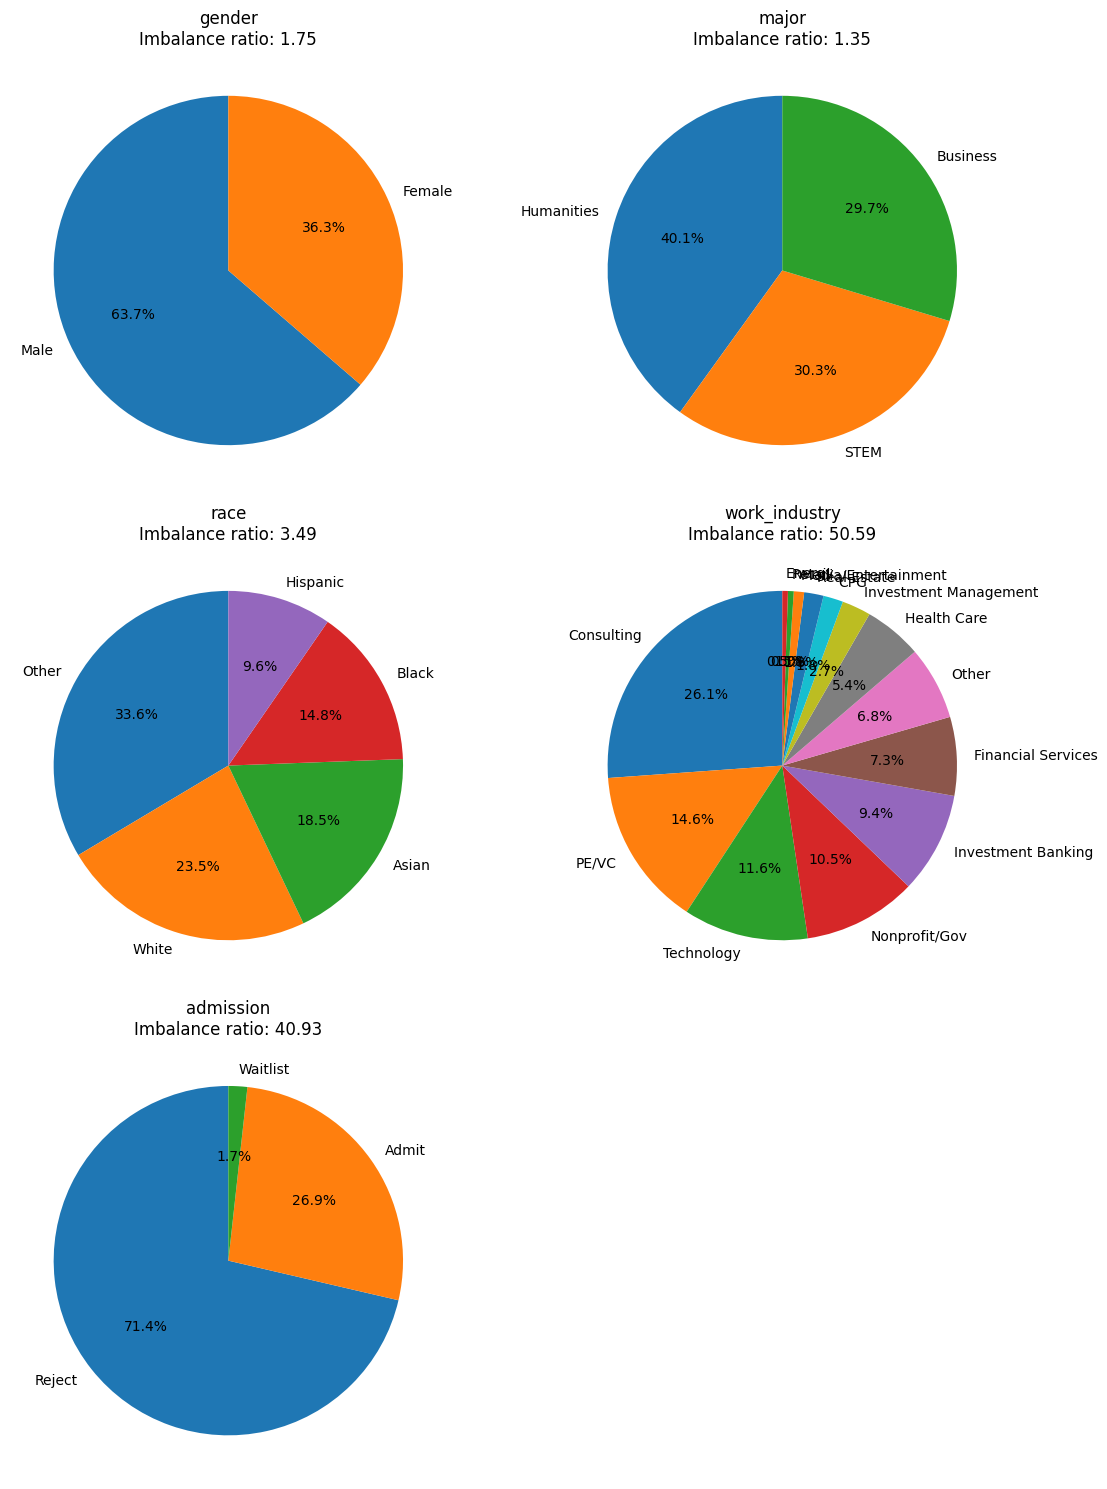

In [ ]:
create_imbalance_pie_chart(df)

In [ ]:
print(analyze_imbalance(df_1, 'admission'))


Analysis for column: admission
Value counts:
0: 4528 (73.10%)
1: 1666 (26.90%)

Imbalance ratio: 2.72
Normalized entropy: 0.58
Gini impurity: 0.39
Simpson's diversity index: 0.39
Interpretation: Mild or no significant imbalance

--------------------------------------------------
None


**Analysis:**

* This dataset shows that there are **4528 non-admitted** cases (73.10%) and **1666 admitted cases** (26.90%), resulting in an imbalance ratio of 2.72. The normalized entropy (0.58), Gini impurity (0.39), and Simpson's diversity index (0.39) indicate a mild imbalance.

* This imbalance is significant in the context of predicting admissions, as it may affect model performance and lead to biased predictions favoring the majority class. Therefore, employing techniques like SMOTE for oversampling the minority class could help improve the model's ability to accurately predict admissions for underrepresented groups.










**3.2 SMOTE Technique**

**Backgorund:** The SMOTE (Synthetic Minority Over-sampling Technique) technique is crucial for addressing class imbalance in our dataset, particularly when the distribution of the target variable reveals a significant disparity between classes. In cases where one class, such as admissions, has substantially more instances than another (e.g., non-admissions), traditional methods like undersampling or simple oversampling can lead to biased models that favor the majority class, resulting in poor predictive performance for the minority class. So by generating synthetic instances of the minority class based on existing samples, SMOTE can improve the feature space, allowing the model to learn more about the characteristics of the minority class without the risk of overfitting.








In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
# Checking the new class distribution after SMOTE
print("Original class distribution:\n", y_train.value_counts())
print("Class distribution after applying SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Original class distribution:
 admission
0    3634
1    1321
Name: count, dtype: int64
Class distribution after applying SMOTE:
 admission
0    3634
1    3634
Name: count, dtype: int64


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check the original distribution of the target variable
print(f"Original target distribution: {Counter(y)}")
sampling_strategy = {0: 4528, 1: 3000}

# Applying SMOTE with the dictionary for multi-class resampling
oversample = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=6)
X_over, y_over = oversample.fit_resample(X, y)

# Checking the new distribution of the target variable after SMOTE
print(f"# of rows before SMOTE: {X.shape[0]}")
print(f"# of rows after SMOTE: {X_over.shape[0]}")
print(f"Resampled target distribution: {Counter(y_over)}")


Original target distribution: Counter({0: 4528, 1: 1666})
# of rows before SMOTE: 6194
# of rows after SMOTE: 7528
Resampled target distribution: Counter({0: 4528, 1: 3000})


**Analysis:** This initial imbalance in the dataset risked skewing the model's predictions toward the majority class. After applying SMOTE, the total rows increased to 7,528, with 4,528 instances of non-admissions and 3,000 instances of admissions. This resampling enhances the representation of the minority class, allowing the model to learn more effectively from both classes. Consequently, the model's predictive performance is expected to improve, providing better insights into the factors influencing admissions in educational settings.








In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 4: Evaluate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8852
Precision: 0.8973
Recall: 0.8673
F1 Score: 0.8821
Confusion Matrix:
[[826  89]
 [119 778]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Analysis:**

* The accuracy of 88.52% suggests that the model performed well overall. The precision of 89.73% indicates that most of the positive predictions were correct, while the recall of 86.73% indicates that there were still some positive instances that the model failed to identify. This is critical because SMOTE aims to improve the model's ability to recognize the minority class imbalances

* The confusion matrix shows that there were 119 false negatives, meaning that the model missed some positive cases. This suggests that while SMOTE improved the model's ability to identify the minority class, there is still room for improvement in recall.



**3.3 Model Class Weights**

**Background:** Using model class weights addresses class imbalance in the data by assigning greater importance to the minority class (admissions) during model training. This approach helps prevent bias toward the majority class (deny) and improves the model's ability to identify admitted candidates effectively. In contexts like educational admissions, this leads to better precision and recall for the minority class, resulting in a more balanced performance and promoting equitable decision-making in the admissions process.








In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)'])

# Fit the model without class weights
clf = LogisticRegression(max_iter=500)  # Increased max_iter to improve convergence
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate performance metrics without weights
accuracy = clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Create a new row for metrics without weights
metrics_without_weights = pd.DataFrame({
    'Model': ['Without Weights'],
    'Accuracy': [accuracy],
    'Precision (macro)': [precision],
    'Recall (macro)': [recall],
    'F1-Score (macro)': [f1]
})

# Check for non-empty metrics before concatenating
if not metrics_without_weights.empty:
    metrics_df = pd.concat([metrics_df, metrics_without_weights], ignore_index=True)

# Compute class weights dynamically based on the classes present in y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {int(cls): weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Fit the model with class weights
clf_weighted = LogisticRegression(class_weight=class_weights_dict, max_iter=500)  # Increased max_iter
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)

# Calculate performance metrics with class weights
accuracy_weighted = clf_weighted.score(X_test, y_test)
precision_weighted = precision_score(y_test, y_pred_weighted, average='macro', zero_division=0)
recall_weighted = recall_score(y_test, y_pred_weighted, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred_weighted, average='macro', zero_division=0)

metrics_with_weights = pd.DataFrame({
    'Model': ['With Weights'],
    'Accuracy': [accuracy_weighted],
    'Precision (macro)': [precision_weighted],
    'Recall (macro)': [recall_weighted],
    'F1-Score (macro)': [f1_weighted]
})

# Check for non-empty metrics before concatenating
if not metrics_with_weights.empty:
    metrics_df = pd.concat([metrics_df, metrics_with_weights], ignore_index=True)

# Output metrics DataFrame
metrics_df

<ipython-input-344-6af679fd16df>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, metrics_without_weights], ignore_index=True)


,Model,Accuracy,Precision (macro),Recall (macro),F1-Score (macro)
0,Without Weights,0.910412,0.901792,0.87028,0.884139
1,With Weights,0.910412,0.881291,0.90588,0.892136


In [ ]:
# Get the row with the maximum F1 score
max_f1_row = metrics_df.iloc[metrics_df['F1-Score (macro)'].idxmax()]
max_f1_row

,1
Model,With Weights
Accuracy,0.910412
Precision (macro),0.881291
Recall (macro),0.90588
F1-Score (macro),0.892136


**Analysis:**

* Both models exhibit high **accuracy** at **91.04%**, indicating effective classification of admissions, but the model without class weights has a higher precision (90.18%) compared to the weighted model (88.13%), suggesting it may produce fewer false positives.

* The weighted model improves **recall** to **90.59%**, indicating better identification of actual admissions, which is crucial for ensuring that qualified candidates, especially from underrepresented backgrounds, are not overlooked.

* The weighted model's **F1-score** of **89.21%** reflects a better balance between precision and recall, making it more suitable for contexts where it’s important to maximize the identification of qualified candidates while maintaining reasonable standards.

**4. BONUS: Model Building and Evaluation**

The following code entails the below:
* Logistic Regression
* Evaluation of the model's performance using metrics (e.g., accuracy, precision, recall, and F1-score)
* Discussion of the strengths and weaknesses of the model and suggest potential improvements.

**Logistic Regression** is a well-suited for model building in the context of this dataset focused on predicting admission outcomes based on various features like GPA, GMAT scores, work experience and more. Additionally, logistic regression efficiently handles the dataset's size without excessive computational demands, offering probabilistic predictions that indicate the likelihood of admission, which enables more nuanced decision-making. It also addresses potential class imbalance by incorporating class weights, ensuring sensitivity to the minority class (e.g., admitted candidates), particularly after applying techniques like SMOTE for balance.








In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separate features and target variable
X = df_1.drop('admission', axis=1)
y = df_1['admission']

oversample = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_over, y_over = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)'],
    'Score': [accuracy, precision, recall, f1]
})

metrics_df

,Metric,Score
0,Accuracy,0.924945
1,Precision (macro),0.924933
2,Recall (macro),0.924970
3,F1-Score (macro),0.924942


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
classification_report_df = pd.DataFrame(report).transpose()
classification_report_df


,precision,recall,f1-score,support
0,0.928493,0.922404,0.925439,915.000000
1,0.921373,0.927536,0.924444,897.000000
accuracy,0.924945,0.924945,0.924945,0.924945
macro avg,0.924933,0.924970,0.924942,1812.000000
weighted avg,0.924968,0.924945,0.924946,1812.000000


**Analysis:**

* The model demonstrates a high **overall accuracy of 92.49%**, indicating it effectively distinguishes between different admission outcomes in the dataset. This level of accuracy is significant, especially in contexts where admissions decisions can have profound implications for candidates' educational and career trajectories.

* With a **macro precision of 92.49%** and **recall of 92.50%**, the model excels in both identifying true positive cases (correctly predicting admissions) and minimizing false positives (as mentioned above), highlighting its reliability in recommending candidates. This balance is crucial for educational institutions seeking to enhance diversity and inclusivity in their admission processes.

* The **F1-score of 92.49%** reflects the model's ability to maintain a strong balance between precision and recall, indicating its suitability for scenarios where both metrics are critical. Given the dataset's focus on admissions, the model's performance suggests it can reliably assist in identifying candidates who not only meet academic criteria but also align with institutional goals for a more equitable representation.








**For Further Improvements (Weaknesses)**

* While the model shows strong performance metrics, several improvements can be made. Improving feature engineering could reveal additional predictive power, and fine-tuning hyperparameters through grid search may optimize logistic regression performance.

* The precision and recall scores suggest some imbalance, indicating that advanced techniques like ensemble methods or sophisticated sampling could enhance minority class performance. Implementing cross-validation would provide better insights into model stability, and exploring non-linear models, such as decision trees or support vector machines, might capsture more nuanced relationships in the data, and improving the model's predictive capability.








**Overall Findings**

* Feature selection through correlation analysis showed that GPA and GMAT scores had the strongest positive correlations with admission, while Recursive Feature Elimination (RFE) confirmed that academic performance and work experience were the most important predictors. Minimal influence was found from variables like race and major.

* The dataset had a severe class imbalance, particularly in admission outcomes, which was addressed using Synthetic Minority Over-sampling Technique (SMOTE) to balance the classes. Logistic regression models were applied with and without class weights, demonstrating that class weighting significantly improved the model's F1-score, which is an important evaluation metric given the imbalanced data for the target variable.






